::::
:::{thebe-button}
:::
::::

# Get thermal data


In [1]:
from boilercore.fits import fit_from_params
from boilercore.models.geometry import GEOMETRY
from boilercore.paths import ISOLIKE, dt_fromisolike
from devtools import pprint
from matplotlib.pyplot import subplots
from pandas import DataFrame, Series, concat, read_csv, read_hdf
from seaborn import lineplot, scatterplot

from boilercv_docs.nbs import display_markdown, init
from boilercv_pipeline.models.column import Col, convert, rename
from boilercv_pipeline.stages.find_objects import FindObjects
from boilercv_pipeline.stages.get_thermal_data import GetThermalData as Params

PARAMS = None

In [2]:
from collections.abc import Iterable

if isinstance(PARAMS, str):
    params = Params.model_validate_json(PARAMS)
else:
    params = Params(context=init(), load_src_from_outs=True)

params.format.set_display_options()
data = params.data
C = params.cols
context = params.context


def preview(
    df: DataFrame,
    cols: Iterable[Col] | None = None,
    index: Col | None = None,
    head: int = 5,
) -> DataFrame:
    """Preview dataframes in this notebook."""
    _cols = [c() for c in cols] if cols else list(df.columns)
    _index: str = index or _cols.pop(0)  # pyright: ignore[reportAssignmentType]
    display_markdown(
        df.set_index(_index)[_cols].head(head), floatfmt=params.format.floatfmt
    )
    return df


def fit(df: DataFrame, flux: Col, sample_temps: Iterable[Col]) -> DataFrame:
    """Fit model function across sample temperatures."""
    models = params.fit.get_models(params.deps.modelfunctions)[0]

    def apply_fit(df: DataFrame) -> "Series[float]":
        return df.loc[:, [c() for c in sample_temps]].apply(
            lambda ser: fit(ser)[0]["q_s"], axis="columns"
        )

    def fit(ser: "Series[float]") -> tuple[dict[str, float], dict[str, float]]:
        return fit_from_params(models, params.fit, GEOMETRY.rods["R"], ser)

    return df.assign(**{flux(): apply_fit})


pprint(params)

GetThermalData(
    context={
        'boilercv_pipeline': BoilercvPipelineCtx(
            roots=Roots(
                data=WindowsPath('c:/Users/Blake/code/softboiler/boilercv/data'),
                docs=WindowsPath('c:/Users/Blake/code/softboiler/boilercv/docs'),
            ),
            kinds={},
            track_kinds=False,
            resolve_rooted=True,
        ),
    },
    deps=Deps(
        context=None,
        stage=WindowsPath('C:/Users/Blake/code/softboiler/boilercv/pipeline/boilercv_pipeline/stages/get_thermal_data'),
        nb=WindowsPath('c:/Users/Blake/code/softboiler/boilercv/docs/notebooks/get_thermal_data.ipynb'),
        thermal=WindowsPath('c:/Users/Blake/code/softboiler/boilercv/data/thermal'),
        modelfunctions=WindowsPath('c:/Users/Blake/code/softboiler/boilercv/data/models'),
    ),
    outs=Outs(
        context=None,
        df=WindowsPath('c:/Users/Blake/code/softboiler/boilercv/data/e230920/thermal.h5'),
        plots=WindowsPath('c:/Users/Bl

In [4]:
sources = [c.source.raw for c in C.sources]
data.dfs.src = preview(
    cols=C.sources,
    df=concat([
        read_csv(
            p,
            usecols=[C.time.source.raw, *sources],
            parse_dates=[C.time.source.raw],
            index_col=C.time.source.raw,
        )
        for p in params.deps.thermal_paths
    ])
    .reset_index()
    .pipe(rename, cols=C.sources)
    .assign(**{
        C.time_elapsed(): lambda df: (
            (df[C.index()] - df[C.index()][0]).dt.total_seconds()
        )
    }),
)

| $\mathsf{Time}$            |   $\mathsf{T_{w3}\ \left(°C\right)}$ |   $\mathsf{T_{w4}\ \left(°C\right)}$ |   $\mathsf{T_{1}\ \left(°C\right)}$ |   $\mathsf{T_{2}\ \left(°C\right)}$ |   $\mathsf{T_{3}\ \left(°C\right)}$ |   $\mathsf{T_{4}\ \left(°C\right)}$ |   $\mathsf{T_{5}\ \left(°C\right)}$ |   $\mathsf{T_{s}\ \left(°C\right)}$ |
|:---------------------------|-------------------------------------:|-------------------------------------:|------------------------------------:|------------------------------------:|------------------------------------:|------------------------------------:|------------------------------------:|------------------------------------:|
| 2024-07-18 16:57:59.835356 |                                 98.0 |                                 97.8 |                                128. |                                124. |                                121. |                                117. |                                108. |                                102. |
| 2024-07-18 16:58:02.729356 |                                 98.0 |                                 97.8 |                                128. |                                124. |                                121. |                                117. |                                108. |                                103. |
| 2024-07-18 16:58:04.732189 |                                 98.1 |                                 97.8 |                                128. |                                124. |                                121. |                                117. |                                108. |                                103. |
| 2024-07-18 16:58:06.724565 |                                 98.1 |                                 97.8 |                                128. |                                124. |                                121. |                                117. |                                108. |                                103. |
| 2024-07-18 16:58:08.734172 |                                 98.1 |                                 97.8 |                                128. |                                124. |                                121. |                                117. |                                108. |                                103. |

In [5]:
only_dests = [C.time, *[c for c in C.dests if c not in C.sources]]
data.dfs.dst = preview(
    cols=only_dests,
    df=(
        DataFrame(read_hdf(params.outs.df))
        if params.load_src_from_outs and params.outs.df.exists()
        else (
            data.dfs.src.set_index(C.index())
            .resample("s")
            .median()
            .assign(**{
                C.video(): lambda df: df.index.isin(
                    df.index[
                        df.index.get_indexer(
                            [
                                dt_fromisolike(match)
                                for p in FindObjects(context=context).contours
                                if (match := ISOLIKE.search(p.stem))
                            ],
                            method="nearest",
                        )
                    ]
                )
            })
            .reset_index()
            .ffill()
            .assign(**{
                C.water_temp(): lambda df: df[[c() for c in C.water_temps]].mean(
                    axis="columns"
                ),
                C.boiling(): lambda df: df[C.water_temp()].max(),
                C.superheat(): lambda df: df[C.surface_temp()] - df[C.boiling()],
                C.subcool(): lambda df: df[C.boiling()] - df[C.water_temp()],
            })
            .pipe(fit, flux=C.flux.source, sample_temps=C.sample_temps)
            .pipe(convert, cols=[C.time_elapsed_min, C.flux])
        )
    )[[c() for c in C.dests]],
)

| $\mathsf{Time}$     |   $\mathsf{t\ \left(s\right)}$ |   $\mathsf{t\ \left(min\right)}$ |   $\mathsf{T_{w}\ \left(°C\right)}$ |   $\mathsf{ΔT_{super}\ \left(K\right)}$ |   $\mathsf{ΔT_{sub}\ \left(K\right)}$ |   $\mathsf{q''\ \left(W/cm^2\right)}$ |   $\mathsf{T_{sat}\ \left(°C\right)}$ | $\mathsf{Video}$   |
|:--------------------|-------------------------------:|---------------------------------:|------------------------------------:|----------------------------------------:|--------------------------------------:|--------------------------------------:|--------------------------------------:|:-------------------|
| 2024-07-18 16:57:59 |                           0.00 |                           0.00   |                                97.9 |                                    4.03 |                                 0.378 |                                  7.91 |                                  98.3 | False              |
| 2024-07-18 16:58:00 |                           0.00 |                           0.00   |                                97.9 |                                    4.03 |                                 0.378 |                                  7.91 |                                  98.3 | False              |
| 2024-07-18 16:58:01 |                           0.00 |                           0.00   |                                97.9 |                                    4.03 |                                 0.378 |                                  7.91 |                                  98.3 | False              |
| 2024-07-18 16:58:02 |                           2.89 |                           0.0482 |                                97.9 |                                    4.30 |                                 0.346 |                                  7.87 |                                  98.3 | False              |
| 2024-07-18 16:58:03 |                           2.89 |                           0.0482 |                                97.9 |                                    4.30 |                                 0.346 |                                  7.87 |                                  98.3 | False              |

In [6]:
data.dfs.resampled = preview(
    cols=only_dests,
    df=(
        data.dfs.dst.set_index(C.index())
        .resample("20s")
        .agg({
            **dict.fromkeys([c() for c in C.dests if c != C.index], "median"),
            C.video(): "max",
        })
        .reset_index()
    ),
)

| $\mathsf{Time}$     |   $\mathsf{t\ \left(s\right)}$ |   $\mathsf{t\ \left(min\right)}$ |   $\mathsf{T_{w}\ \left(°C\right)}$ |   $\mathsf{ΔT_{super}\ \left(K\right)}$ |   $\mathsf{ΔT_{sub}\ \left(K\right)}$ |   $\mathsf{q''\ \left(W/cm^2\right)}$ |   $\mathsf{T_{sat}\ \left(°C\right)}$ | $\mathsf{Video}$   |
|:--------------------|-------------------------------:|---------------------------------:|------------------------------------:|----------------------------------------:|--------------------------------------:|--------------------------------------:|--------------------------------------:|:-------------------|
| 2024-07-18 16:57:40 |                           0.00 |                            0.00  |                                97.9 |                                    4.03 |                                 0.378 |                                  7.91 |                                  98.3 | False              |
| 2024-07-18 16:58:00 |                           9.90 |                            0.165 |                                97.9 |                                    4.52 |                                 0.325 |                                  7.85 |                                  98.3 | False              |
| 2024-07-18 16:58:20 |                          29.9  |                            0.499 |                                97.9 |                                    4.44 |                                 0.335 |                                  7.88 |                                  98.3 | False              |
| 2024-07-18 16:58:40 |                          49.9  |                            0.832 |                                97.9 |                                    4.59 |                                 0.405 |                                  7.89 |                                  98.3 | False              |
| 2024-07-18 16:59:00 |                          70.0  |                            1.17  |                                97.9 |                                    4.84 |                                 0.415 |                                  7.82 |                                  98.3 | False              |

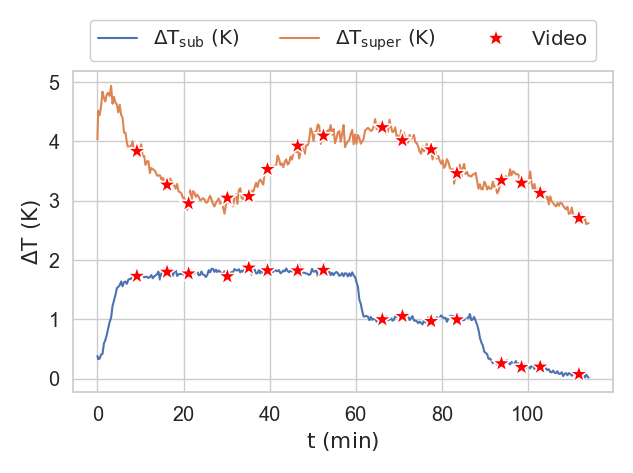

In [6]:
data.plots.subcool_superheat, ax = subplots()
lineplot(
    ax=ax,
    zorder=1,
    data=data.dfs.resampled.set_index(C.time_elapsed_min())[
        [C.subcool(), C.superheat()]
    ],
    dashes=False,
    errorbar=None,
)
scatterplot(
    ax=ax,
    s=10 * params.format.marker_scale,
    markers={C.video(): "*"},
    palette={C.video(): "red"},
    data=data.dfs.resampled.assign(**{
        C.video(): lambda df: df[df[C.video()]][C.superheat()]
    }).set_index(C.time_elapsed_min())[[C.video()]],
)
scatterplot(
    ax=ax,
    s=10 * params.format.marker_scale,
    markers={C.video(): "*"},
    palette={C.video(): "red"},
    data=data.dfs.resampled.assign(**{
        C.video(): lambda df: df[df[C.video()]][C.subcool()]
    }).set_index(C.time_elapsed_min())[[C.video()]],
    legend=False,
)
ax.set_ylabel(C.subcool.without_subscript)
params.format.move_legend(ax)

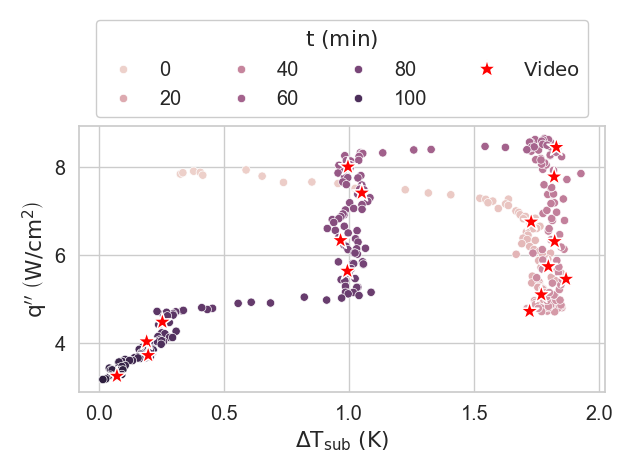

In [8]:
data.plots.subcool, ax = subplots()
scatterplot(
    ax=ax, data=data.dfs.resampled, x=C.subcool(), y=C.flux(), hue=C.time_elapsed_min()
)
scatterplot(
    ax=ax,
    s=10 * params.format.marker_scale,
    markers={C.video(): "*"},
    palette={C.video(): "red"},
    data=data.dfs.resampled.assign(**{
        C.video(): lambda df: df[df[C.video()]][C.flux()]
    }).set_index(C.subcool())[[C.video()]],
)
ax.get_legend().set_title(C.time_elapsed_min())  # pyright: ignore[reportOptionalMemberAccess]
params.format.move_legend(ax, ncol=4)

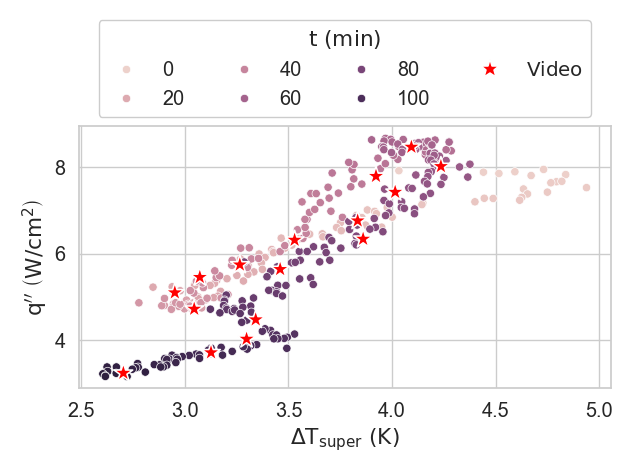

In [9]:
data.plots.superheat, ax = subplots()
scatterplot(
    ax=ax,
    data=data.dfs.resampled,
    x=C.superheat(),
    y=C.flux(),
    hue=C.time_elapsed_min(),
)
scatterplot(
    ax=ax,
    s=10 * params.format.marker_scale,
    markers={C.video(): "*"},
    palette={C.video(): "red"},
    data=data.dfs.resampled.assign(**{
        C.video(): lambda df: df[df[C.video()]][C.flux()]
    }).set_index(C.superheat())[[C.video()]],
)
ax.get_legend().set_title(C.time_elapsed_min())  # pyright: ignore[reportOptionalMemberAccess]
params.format.move_legend(ax, ncol=4)